# SpaCcLink tutorial

## 1. Load dataset

In [2]:
import os
current_path = os.getcwd()
print("当前工作路径：", current_path)
# 设置新的工作路径
new_path = "../../"
os.chdir(new_path)
print("新的工作路径：", os.getcwd())

input_dir = "./datasets/melanoma/"

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

adata = sc.read_h5ad(os.path.join(input_dir, "melanoma.h5ad"))
sc.pp.log1p(adata)
sc.pp.filter_genes(adata, min_cells=5)
genes_use = adata.var_names
adata.obs['celltype'] = adata.obs.idxmax(axis=1)
adata.obs['X'] = adata.obsm['spatial'][:,0]
adata.obs['Y'] = adata.obsm['spatial'][:,1]

d:\python\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
d:\python\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


C:\Users\Liu\AppData\Roaming\Python\Python39\site-packages\scanpy\plotting\_anndata.py:316: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(adata.obs[key]):


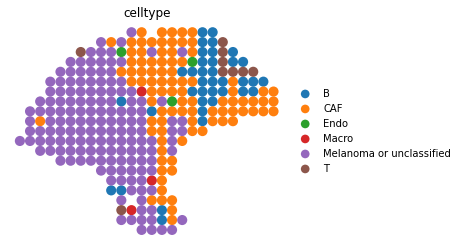

In [4]:
# 创建Figure对象和Axes对象
fig, ax = plt.subplots(figsize=(5, 4))

ax.axis('off')
sc.pl.scatter(adata, x='X', y='Y', color = "celltype", ax=ax)



## 2. Load prior knowledge data

lr_db: Ligand-Receptor db

rec_tg: Receptor-Target genes(TG) db. This database is then used for downstream modules identification of receptors.

tftg: TF(Transcription factor)-TG db

In [5]:
from utils.utils_read import getInteractionDB
genes_use = adata.var_names
lr_db, pathways, rec_tg, tftg = getInteractionDB(genes_use, species="Human")

## 3. Model training and inference

### 3.1 Build the dataset used for traing
The training data is under save_dir.

In [ ]:
from utils.build_dataset import build_dataset

save_dir = "./model_data/melanoma/"
rec_tg[rec_tg.columns[:2]].to_csv(os.path.join(save_dir, "rec_tg.csv"))
build_dataset(adata, pathways, save_dir)

### 3.2 Training.

F1 score can be used to tune model parameters. And function predict() can be used to identify downstream gene modules associated with the receptors.

In [ ]:
from model_main import train, test, predict
train()
f1 = test()
predict()


## 4. Cell-cell communication analysis 

In this step, the division of ligand receptor pairs is performed. This step is mainly due to the fact that the prior database does not provide information about the mode of action, and different interaction modes have different communication scopes.

In [ ]:
from utils.utils_split import splitLR
lrs = splitLR(adata, lr_db, shuffle_num=500)

### 4.1 Calculate the downstream impact score of receptors

In [11]:
from utils.utils_anlysis import cal_Influence_score
groupby = 'celltype'
relations = pd.read_csv(os.path.join(input_dir, "top_pairs.csv"))
module_score = cal_Influence_score(adata, relations, groupby)
r_genes = np.unique(module_score.columns)
lrs = lrs.loc[lrs['receptor'].isin(r_genes)]
r_genes = np.unique(module_score.columns)
lrs = lrs.loc[lrs['receptor'].isin(r_genes)]

### 4.2 Ligand-receptor spatial dependence analysis. 

This step is used to identify LR pairs with global spatial dependencies and further identify local communication hotspots 

In [13]:
from utils.utils_spatial import spatial_statistics
pairs, local_i = spatial_statistics(adata, lrs, iter_num=500)

Identification of communication between cell types

In [15]:
from utils.utils_anlysis import getCelltypeInteraction
source_types=['B', 'CAF','Melanoma or unclassified', 'T']
target_types =['B', 'CAF','Melanoma or unclassified', 'T']
celltype_interaction = getCelltypeInteraction(adata, pairs, source_types, target_types, groupby, iter_num=500,thre_p=0.05)

### 4.3 Spatial pattern recognition

Non-negative Matrix Factorization (NMF) was employed to detect and define spatial patterns by leveraging receptor downstream influence scores. Subsequently, the Kneedle package was utilized to determine the optimal k value.

In [16]:
from sklearn.decomposition import NMF
from sklearn.metrics import mean_absolute_error
from kneed import KneeLocator

# Calculate the reconstruction error for different k values
k_values = range(1, 10)  
errors = []

A = module_score[np.unique(lrs.loc[celltype_interaction.lr].receptor)]
for k in k_values:
    nmf = NMF(n_components=k)
    X_train_nmf = nmf.fit_transform(A)
    X_train_approx = nmf.inverse_transform(X_train_nmf)
    error = mean_absolute_error(A, X_train_approx)
    errors.append(error)

# Find the inflection point with the Kneedle bag (optimal k value)
kneedle = KneeLocator(k_values, errors, curve='convex', direction='decreasing')
best_k = kneedle.knee
print(best_k)

2


d:\python\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
d:\python\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
d:\python\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


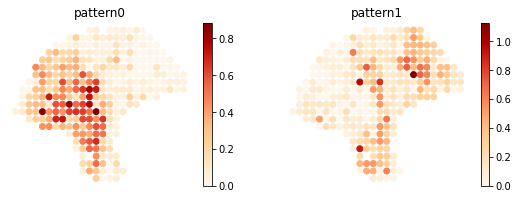

In [18]:
nmf = NMF(n_components=best_k)
W = nmf.fit_transform(A)  # 得到分解后的 W 矩阵
H = nmf.components_  # 得到分解后的 H 矩阵

labels = ["pattern"+str(i) for i in range(W.shape[1])]
df = pd.DataFrame(W, index= adata.obs_names, columns=labels)
fig = plt.figure(figsize=(24,3))
n = int(np.ceil(W.shape[1]/5))
for i in range( W.shape[1]):
    plt.subplot(n,5,i+1)
    plt.scatter(adata.obs['X'], adata.obs['Y'], 
                c=df[labels[i]],cmap = 'OrRd',)
    plt.colorbar()
    plt.title(labels[i])
    plt.axis("off")

Visualize the top genes in the load matrix

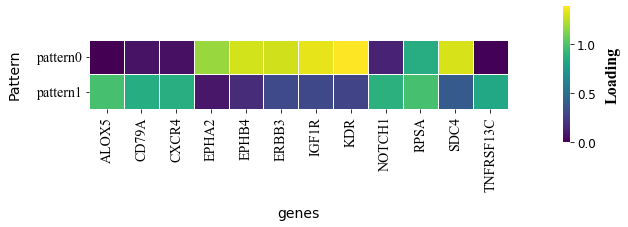

In [20]:
from utils.utils_plot import pl_heatmap, pl_circle

genes = A.columns[np.unique(np.argsort(-H, axis=1)[:, :6])]
df = pd.DataFrame(H, index = labels, columns = A.columns)
df = df[genes]
pl_heatmap(df, xlabel="genes", ylabel = "Pattern", title = "", barlabel= "Loading",cmap="viridis")

Visualize the local communication hotspots of CXCL12-CXCR4 based on the previous spatial dependence analysis.

(1.75, 29.25, 6.0, 28.0)

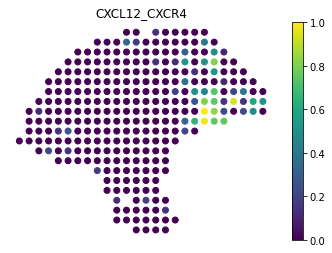

In [21]:
lr = "CXCL12_CXCR4"
t= local_i.abs()
t = t/ t.max()

plt.scatter(adata.obs['X'], adata.obs['Y'], 
            c=t[lr])
plt.colorbar()
plt.title(lr)
plt.axis("off")

### 4.4 Cellular communication analysis at the cell type level

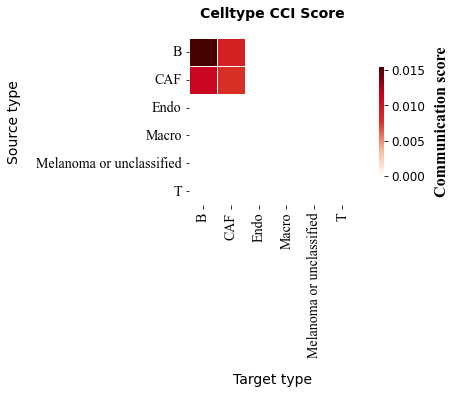

In [22]:

from utils.utils_anlysis import computeCciScore, computeCelltypeCciScore
cci_matrix = computeCciScore(adata, pairs, module_score, local_i)

celltype_cci = computeCelltypeCciScore(cci_matrix, adata.obs[groupby], lr)
pl_heatmap(celltype_cci, xlabel="Target type", ylabel = "Source type", title = "Celltype CCI Score", barlabel= "Communication score",figsize=(4,4))

Different display forms (circle plot is optional).


In [23]:
clusters = np.unique(adata.obs['celltype'])
colors = dict(zip(clusters, adata.uns['celltype_colors']))
pl_circle(celltype_cci,min_percentile=0.2,colors=colors,save_path="circle图.pdf")

### 4.5 Downstream signal analysis

Identify the signaling pathway from the receptor to the tf and then to the target gene

In [24]:
from utils.utils_read import getPairs
from utils.utils_anlysis import findReceptorToTargetPath, findTopPath
rec_tf = getPairs("./prior_db/rec_tf.csv", genes_use, "Human")
findReceptorToTargetPath(adata, celltype_interaction, relations, pathways, rec_tf, tftg)



B
CAF
Melanoma or unclassified
T


In [25]:
n_target = 5
n_tf = 3
top_paths = findTopPath(adata, n_target, n_tf)

B
CAF
Melanoma or unclassified
T


Pathway visualization

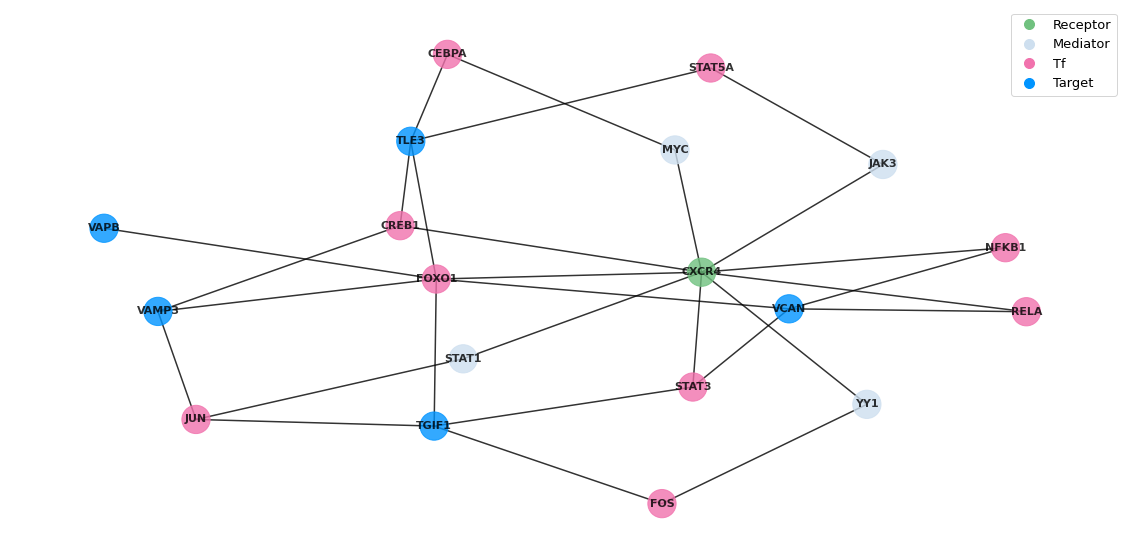

In [26]:
from utils.utils_plot import pl_pathway
celltype = 'B'
receptor = 'CXCR4'
pl_pathway(top_paths, adata.uns['rec_tf_tg'], celltype, receptor)